In [1]:
%% initialization

format short; format compact;
clear all; clc; close all;

%plot inline

## load data

In [3]:
rx_s = load('data/dat_rx.mat');
rx = rx_s.rx;

## data cleaning

removing single occurrences of a 1 or a 0

In [21]:
clean_count = [];

for i = 2:length(rx)
    % if 0,1,0
    if rx(i-1) == 0 & rx(i) == 1 & rx(i+1) == 0
        rx_c(i) = 0;
        clean_count = [clean_count,0];
    % if 1,0,1
    elseif rx(i-1) == 1 & rx(i) == 0 & rx(i+1) == 1
        rx_c(i) = 1;
        clean_count = [clean_count,1];
    else
        rx_c(i) = rx(i);
    end
end
rx_c(1) = 1;

fprintf('number of bits cleaned: %d\n',length(clean_count))

number of bits cleaned: 8


## data processing

setting some parameters

In [79]:
spb = 128;      % samples per bit
rx_d = [];      % discretized rx
k_check = [];   % bit length matrix, debug
j = 1;          % signal indexer
k=1;            % bit counter

iterate through and discretize the signal

In [80]:
for i = 2:length(rx_c)
    % if bits are the same
    if rx_c(i) - rx_c(i-1) == 0 
        k=k+1;
    % if 0 -> 1
    elseif rx_c(i) - rx_c(i-1) == 1
        k_check = [k_check,k];  % debug
        n = round(k/spb);
        rx_d(j:j+n) = 0;
        j = j + n;
        k = 1;
    % if 1 -> 0
    elseif rx_c(i) - rx_c(i-1) == -1
        k_check = [k_check,k];  % debug
        n = round(k/spb);
        rx_d(j:j+n) = 1;
        j = j + n;
        k = 1;
    end
end

rx_n = rx_d;

## plot comparison

This compares a narrow slice of a plot of the original cleaned signal `rx_c` (cleaned means the random 1's and 0's removed) with the discretized version `rx_d` with `spb = 128`.

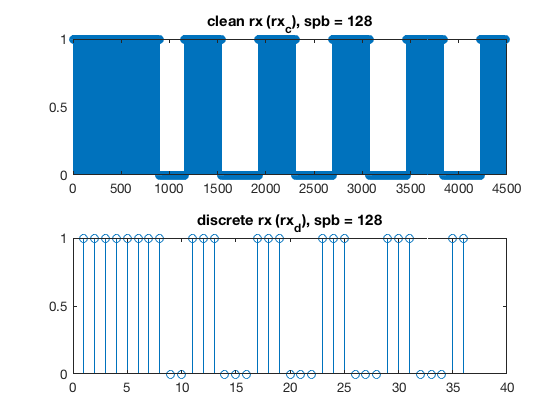

In [46]:
plt_st = 75;
plt_end = 110;
subplot(2,1,1)
stem(rx_c(plt_st*spb:plt_end*spb))
title('clean rx (rx_c), spb = 128')
subplot(2,1,2)
stem(rx_d(plt_st:plt_end))
title('discrete rx (rx_d), spb = 128')

This comparison is the same as above except `spb = 384`.

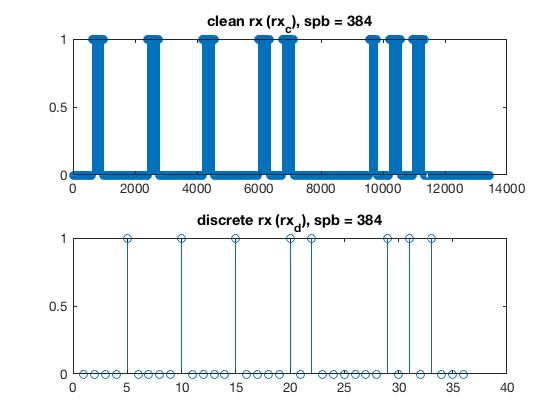

In [71]:
plt_st = 75;
plt_end = 110;
subplot(2,1,1)
stem(rx_c(plt_st*spb:plt_end*spb))
title('clean rx (rx_c), spb = 384')
subplot(2,1,2)
stem(rx_d(plt_st:plt_end))
title('discrete rx (rx_d), spb = 384')

When `spb = 128` is used `0`'s are *missed*, you can see the discrete version creeping left.<br>
When `spb = 384` is used `0`'s are *added*, you can see the discrete version creeping right.

## sample length analysis

This compares the length of the discretized signal `rx_d` to the `length(rx_c)/spb`. The two values should match but because of the extra or missing `0`'s from above they do not.

In [51]:
fprintf('\nsamples in rx_c: %f\n',length(rx_c)/spb)
fprintf('samples in data_rx_r: %d\n',length(rx_d))


samples in rx_c: 82031.250000
samples in data_rx_r: 82068


<br>This table shows the frequency distribution of samples per bit found in `rx_c`.
- **index:** just an index
- **bit_len:** the number of samples per bit (how many straight `1`'s or `0`'s there were until it changed)
- **freq:** the number of times this length was found in `rx_c`
- **percentage:** the frequency as a percentage of total samples in `rx_c`
- **spb_one:** `bit_len` divided by `spb = 384`
- **spb_two:** `bit_len` divided by `spb = 128`

In [86]:
k_tabd = tabulate(k_check);
k_tab = k_tabd(k_tabd(:,2) > 0,:);
k_tab(:,4) = k_tab(:,1)/384;
k_tab(:,5) = k_tab(:,1)/128;
k_tab(:,6) = linspace(1,length(k_tab),length(k_tab));

varNames = {'index','bit_len','freq','percentage','spb_one','spb_two'};
k_table = table(k_tab(:,6),k_tab(:,1),k_tab(:,2),k_tab(:,3),k_tab(:,4),k_tab(:,5),'VariableNames',varNames);
k_table(1:48,:)

ans =
  48x6 table
    index    bit_len    freq    percentage    spb_one    spb_two
    _____    _______    ____    __________    _______    _______
      1         97         1     0.029525      0.2526    0.75781
      2        127         3     0.088574     0.33073    0.99219
      3        128         1     0.029525     0.33333          1
      4        129         1     0.029525     0.33594     1.0078
      5        254         1     0.029525     0.66146     1.9844
      6        255         5      0.14762     0.66406     1.9922
      7        256        23      0.67907     0.66667          2
      8        257        44       1.2991     0.66927     2.0078
      9        382         6      0.17715     0.99479     2.9844
     10        383       248       7.3221      0.9974     2.9922
     11        384      1867       55.123           1          3
     12        385       180       5.3144      1.0026     3.0078
     13        510         7      0.20667      1.3281     3.9844
     1

You can see 55% of the bits are 384 samples long (index 11) and 68% are between 383 and 385. But look at the column `spb_one`, only one cleanly divided into an integer (index 11) and there are gaps where other integers should be. It jumps from 2.88 (index 25) to 3.32 (index 26). I can understand some variance but would expect them to cluster around the integers...
<br>

The problem is all these other bit lengths are really difficult to process because the discretizer is just rounding the numbers in columns `spb_one` and `spb_two` depending on which `spb` I use. Say for index 15, should that be one `0` or two `0`'s? The variability is all over the place.<br>

Below is a distribution of the bit length clusters.

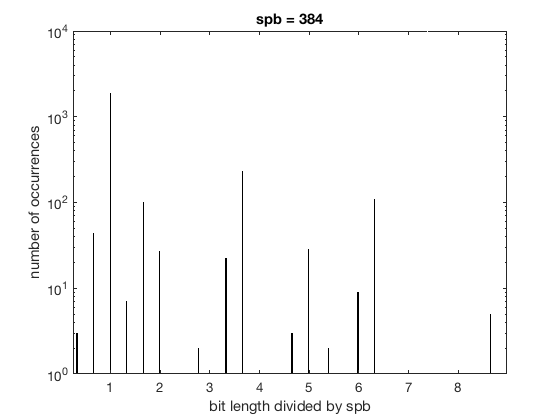

In [78]:
kx = k_tab(1:48,4);
ky = k_tab(1:48,2);

bar(kx,ky)
set(gca,'yscale','log')
xlabel('bit length divided by spb');
ylabel('number of occurrences');
title('spb = 384')

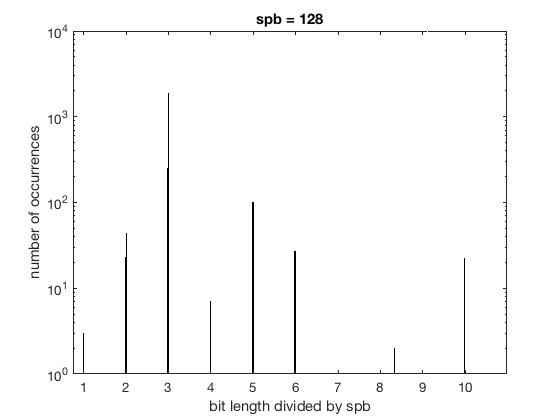

In [87]:
kx = k_tab(1:30,5);
ky = k_tab(1:30,2);

bar(kx,ky)
set(gca,'yscale','log')
xlabel('bit length divided by spb');
ylabel('number of occurrences');
title('spb = 128')